notebook creates a violin plot of proportion of switches by agent type (RNN vs Human)

In [12]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib
import ptitprince as pt

sns.set(style="whitegrid",font_scale=2)
plt.rcParams.update({'font.size': 30})
plt.rcParams["figure.figsize"] = (8, 8)

In [2]:
#move up in directory
os.chdir('../')

from helpers import dot2_

In [3]:
os.getcwd()

'C:\\Users\\deniz\\Desktop\\PhD\\p1_generalization'

In [4]:
# Config 

### Human
PATH_HUMAN_DATA = 'data/human_raw_data/'
HUMAN_DATA_NAME = 'data_chakroun_wiehler.csv'

# number of human subjects
N_SUBS = 31
# number of trials (human & RNN)
N_TRIALS = 300

### RNN
PATH_RNN_DATA ='data/rnn_raw_data/'
RNN_FILE_NAME = 'lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_0_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}'

# number of RNN instances
N_IDS = 30
# number of random walk instances
N_WALKS = 3

In [5]:
# get human switch proportions
human_df = pd.read_csv(open(PATH_HUMAN_DATA + HUMAN_DATA_NAME, 'rb'), index_col=0)
human_switch_props = []

for sub in range(1,N_SUBS+1):
    
    sub_df = human_df.loc[human_df.vp == sub,:]
    choice = sub_df['choice'].to_numpy()
    is_switch = [int(choice[t] != choice[t-1]) for t in range(1, N_TRIALS) if choice[t] != 0]
    human_switch_props.append(np.mean(is_switch))

In [6]:
# get LSTM switch proportions
rnn_file_path = PATH_RNN_DATA + RNN_FILE_NAME

rnn_switch_props = []

for id_ in range(N_IDS):
        for walk in range(1,N_WALKS + 1):
            
            d = pickle.load(open(rnn_file_path.format(id_, walk), 'rb'))
            df = d.reset_index()
            rnn_switch_props.append(np.mean(df['is_switch']))

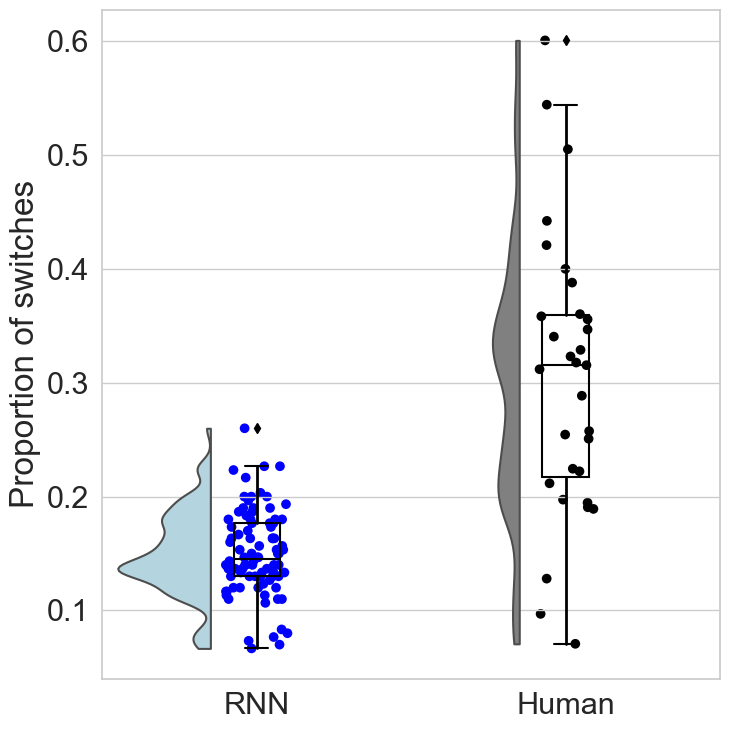

In [13]:
# plotting
plot_df = pd.DataFrame({"switch": rnn_switch_props + human_switch_props,
                       "type": ['RNN'] * len(rnn_switch_props)  + ['Human'] * len(human_switch_props)})

# plotting the clouds
f, ax = plt.subplots()
dy="switch"; dx="type"; ort="v"; pal = {"RNN": "lightblue", "Human": "grey"}#sns.color_palette(n_colors=2)
ax=pt.half_violinplot( x = dx, y = dy, data = plot_df, palette = pal, bw = .2, cut = 0.,
                      scale = "area", width = .6, inner = None, orient = ort)


pal1 = {"RNN": "blue", "Human": "black"}
ax=sns.stripplot( x = dx, y = dy, data = plot_df, palette = pal1, edgecolor = "white",
size = 7, jitter = 1, zorder = 0, orient = ort)

x=sns.boxplot( x = dx, y = dy, data = plot_df, color = "black", width = .15, zorder = 10,\
showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
saturation = 1, orient = ort)

plt.ylabel('Proportion of switches')
plt.xlabel('')

plt.tight_layout()
plt.savefig('../p1_generalization/plots/Figure_2_C.svg', dpi = 600)


In [8]:
# save data for jasp analysis

plot_df.to_csv('data/intermediate_data/jasp_analysis/switch_t_test_data.csv')

# Posterior Predictive Checks

In [9]:
ppreds = pd.read_csv('data/intermediate_data/modeling/ppred_fig_2_switch_probs.csv')

In [10]:
ppreds

,Unnamed: 0,switch_prob,type
0,1,0.190635,RNN
1,2,0.284281,RNN
2,3,0.297659,RNN
3,4,0.227425,RNN
4,5,0.193980,RNN
...,...,...,...
116,117,0.304348,Human
117,118,0.357860,Human
118,119,0.414716,Human
119,120,0.277592,Human


In [11]:
ppred_human_switch_probs = ppreds.switch_prob[ppreds.type == 'Human']
ppred_rnn_switch_probs = ppreds.switch_prob[ppreds.type == 'RNN']

In [12]:
plot_df_human = pd.DataFrame({"switch": list(human_switch_props) + list(ppred_human_switch_probs),
                       "type": ['Observed'] * len(human_switch_props)  + ['Simulated'] * len(ppred_human_switch_probs)})

In [13]:
plot_df_rnn = pd.DataFrame({"switch": list(rnn_switch_props) + list(ppred_rnn_switch_probs),
                       "type": ['Observed'] * len(rnn_switch_props)  + ['Simulated'] * len(ppred_rnn_switch_probs)})

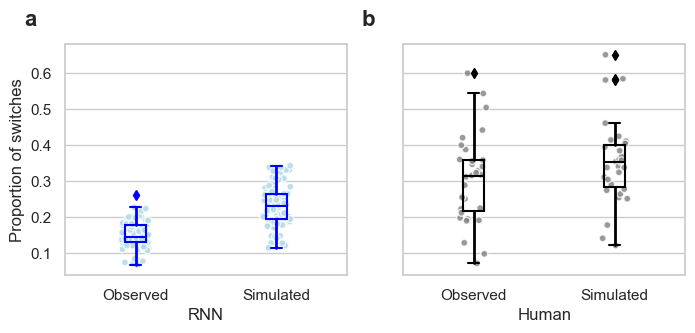

In [15]:
sns.set(style="whitegrid",font_scale=1)
plt.rcParams.update({'font.size': 10})

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)


#my_pal = {"Observed": "white", "Simulated": "white"}
sns.stripplot(ax=axes[0], x='type', y='switch', data = plot_df_rnn,color = 'lightblue', 
              edgecolor = "white", alpha = 0.8, size = 5, linewidth = 1)

sns.boxplot(ax=axes[0], x='type', y='switch', data = plot_df_rnn, color = "black", width = .15, zorder = 10,\
showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
saturation = 1, orient = ort)

axes[0].set(xlabel='RNN', ylabel='Proportion of switches')

###

box_patches = [patch for patch in axes[0].patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
    box_patches = axes[0].artists
num_patches = len(box_patches)
lines_per_boxplot = len(axes[0].lines) // num_patches
for i, patch in enumerate(box_patches):
    # Set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = 'blue'#patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in axes[0].lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers

###

axes[0].text(-0.1, 1.15, "a", transform=axes[0].transAxes,
  fontsize=16, fontweight='bold', va='top', ha='right')

axes[1].text(-0.1, 1.15, "b", transform=axes[1].transAxes,
  fontsize=16, fontweight='bold', va='top', ha='right')

sns.stripplot(ax=axes[1], x='type', y='switch', data = plot_df_human,color = 'grey', 
              edgecolor = "white", alpha = 0.8, size = 5, linewidth = 1)
sns.boxplot(ax=axes[1], x='type', y='switch', data = plot_df_human, color = "black", width = .15, zorder = 10,\
showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
saturation = 1, orient = ort)

axes[1].set(xlabel='Human', ylabel='')


plt.savefig('../p1_generalization/plots/figure_2_ppred_labels.jpeg', dpi = 600, bbox_inches='tight')
